The implementation here follows more or less the one from the lecture 

In [54]:
import numpy as np
from fractions import Fraction
import qiskit.visualization
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from matplotlib import pyplot as plt

In [55]:
def sim(circuit, simulator, shots,x_val,y_val,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simGetCounts(circuit, simulator, shots,), title=rf" {x_val}+{y_val} mod {N} = ${(x_val+y_val)%N }_{{10}}$ = ${((x_val+y_val)%N):0{n_qubits}b}_{{2}}$ "))
def simMul(circuit, simulator, shots,x_val,y_val,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simGetCounts(circuit, simulator, shots,), title=rf" {x_val}*{y_val} mod {N} = ${(x_val*y_val)%N }_{{10}}$ = ${((x_val*y_val)%N):0{n_qubits}b}_{{2}}$ "))
def simMulExp(circuit, simulator, shots,x_val,y_val,a,N,n_qubits):
    display(qiskit.visualization.plot_distribution(simGetCounts(circuit, simulator, shots,), title=rf" {x_val}*{y_val}^{a} mod {N} = ${(x_val*y_val**a)%N }_{{10}}$ = ${((x_val*y_val**a)%N):0{n_qubits}b}_{{2}}$ "))


def simGetCounts(circuit, simulator, shots):
    return simulator.run(qiskit.transpile(circuit, simulator),shots=shots).result().get_counts(0)

In [56]:
def adder(n_qubits,y):
    qr = QuantumRegister(n_qubits,name="q")
    qc = QuantumCircuit(qr,name="Add")
    qft = QFT(n_qubits, do_swaps=False)
    qc.append(qft,qr )
    
    # Apply controlled phase rotations
    for i in range(n_qubits):
            theta = 2 * np.pi*y / (2 ** (i + 1))
            qc.p(theta, qr[i])
    # Apply inverse QFT 
    iqft = QFT(n_qubits, do_swaps=False).inverse()
    qc.append(iqft, qr)

    return qc.to_instruction()

In [57]:
def isLess(n_qubits,y):
    """
    the last 2 qubits are a and c respectivly , the other are the data register , the final result is saved in c.
    """
    qubits = list(range(n_qubits))
    x = qubits[:-2]
    a = qubits[-2]
    c = qubits[-1]
    qc = QuantumCircuit(n_qubits,name="isLess")
    add_plus_y = adder(n_qubits-1,y)
    add_minus_y = adder(n_qubits-1,-y)
    qc.append(add_minus_y, x+ [a])
    qc.cx(a,c)
    qc.append(add_plus_y, x+ [a])
    return qc.to_instruction()

In [58]:
def Cadder(n_qubits,y):
    """
    the first qubit is the control qubit, the rest are data qubits
    """
    qr = QuantumRegister(n_qubits-1,name="q")
    control = QuantumRegister(1,name="control")
    qc = QuantumCircuit(control,qr,name="CAdd")
    qft = QFT(n_qubits-1, do_swaps=False)
    qc.append(qft,qr )
    
    # Apply controlled phase rotations
    for i in range(n_qubits-1):
            theta = 2 * np.pi*y / (2 ** (i + 1))
            qc.cp(theta,control, qr[i])
    # Apply inverse QFT 
    iqft = QFT(n_qubits-1, do_swaps=False).inverse()
    qc.append(iqft, qr)

    return qc.to_instruction()

In [59]:
def CisLess(n_qubits,y):
    """
    needs n+3 qubits for n bit number
    the first qubit is the control, qubit,the last 2 qubits are a and c respectivly , the other are the data register , the final result is saved in c.
    """

    qubits = list(range(n_qubits))
    control = qubits[0]
    x = qubits[1:-2]
    a = qubits[-2]
    c = qubits[-1]
    qc = QuantumCircuit(n_qubits,name="isLess")
    add_plus_y = Cadder(n_qubits-1,y)
    add_minus_y = Cadder(n_qubits-1,-y)
    qc.append(add_minus_y,[control]+ x+ [a])
    qc.cx(a,c)
    qc.append(add_plus_y, [control]+x+ [a])
    return qc.to_instruction()

## Controlled adder mod N

In [60]:
def CaddModN(n_qubits, y,N):
    
    """
    needs n+4 qubits for an n bit long number
    the first qubit is the control, qubit,the last 3 qubits are a , c1 and c2 respectivly , the other are the data register , the final result is saved in x.
    """
    qubits = list(range(n_qubits))
    control = qubits[0]
    x = qubits[1:-3]
    a = qubits[-3]
    c1 = qubits[-2]
    c2 = qubits[-1]
    y = y%N
    

    qc = QuantumCircuit(n_qubits,name="CaddModN")
    isLess_N = CisLess(n_qubits-1,N)
    isLess_N_minus_y = CisLess(n_qubits-1,N-y)
    isLess_y = CisLess(n_qubits-1,y)
    add_y_minus_N = Cadder(n_qubits-3,y-N) #need to be with control a
    add_y = Cadder(n_qubits-3,y) #need to be with control a
    qc.append(isLess_N,[control]+x+[a]+[c1])
    qc.append(isLess_N_minus_y,[control]+x+[a]+[c2])

    qc.x(c2)
    qc.ccx(c1,c2,a)
    qc.x(c2)
    qc.append(add_y_minus_N,[a]+x)
    qc.x(c2)
    qc.ccx(c1,c2,a)
    qc.x(c2)

    qc.ccx(c1,c2,a)
    qc.append(add_y,[a]+x)
    qc.ccx(c1,c2,a)


    qc.append(isLess_y,[control]+x+[a]+[c2])
    qc.cx(c1,c2)
    qc.append(isLess_N,[control]+x+[a]+[c1])
    return qc.to_instruction()


In [61]:
x_val =4
y_val = 9
N_val=5
n_qubits = max(int(np.ceil(np.log2(x_val)+1)),int(np.ceil(np.log2(N_val)+1)) ) 

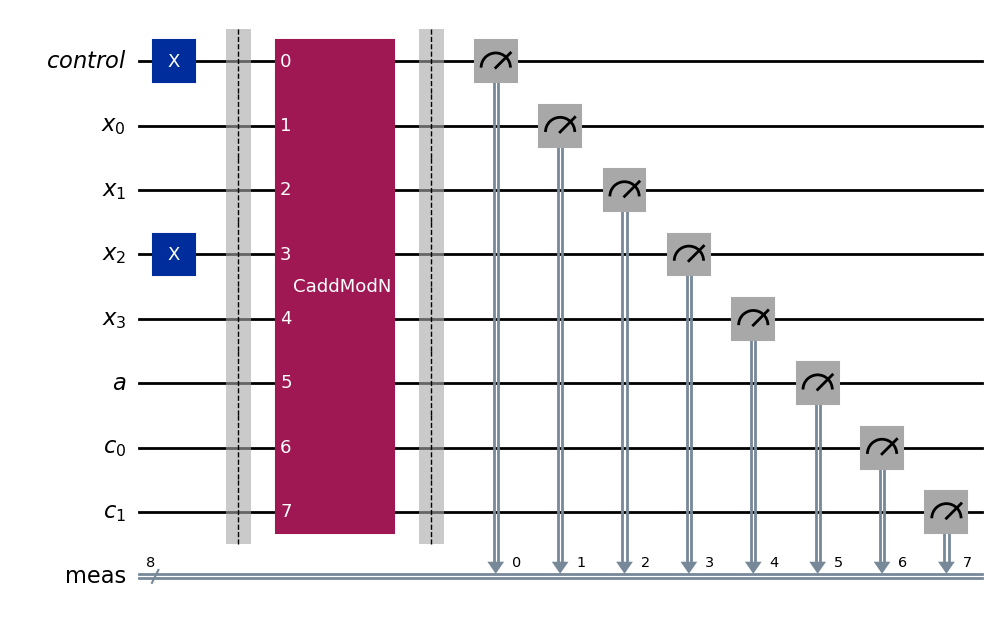

In [62]:
qr = QuantumRegister(n_qubits,'x')
a = QuantumRegister(1,'a')
c = QuantumRegister(2,'c')
control = QuantumRegister(1,'control')
circ = QuantumCircuit(control,qr,a,c)
for i in range(n_qubits):
        if (x_val & (1 << i)):
            circ.x(qr[i])
circ.x(control)
circ.barrier()

circ.append(CaddModN(n_qubits+4,y_val,N_val),circ.qubits[:])
circ.measure_all()
circ.draw('mpl')


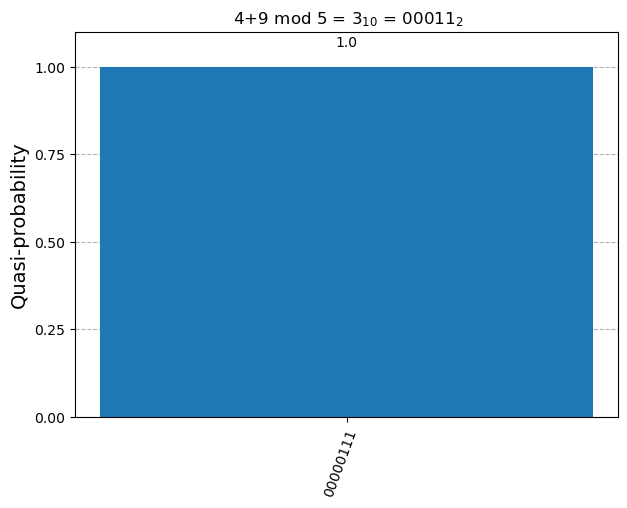

In [63]:
sim(circ,AerSimulator(),1000,x_val,y_val,N_val,5)

## Controlled multiplier mod N

In [64]:
def summands(y,N,n_qubits):
    r = np.zeros(n_qubits)
    for i in range(0,n_qubits):
        s = 0
        for j in range(0,n_qubits):
            s = s+int(np.binary_repr(y,n_qubits)[::-1][j])*2**(i+j)
        r[i] = s % N
    return r

In [65]:
def eEa(a,b):
    if (a==0): 
        return (b,0,1)
    gcd, x,y, = eEa(b%a,a)
    return (gcd,y-(b//a)*x,x)

def moduloinverse(a,n):
    gcd, x,_ = eEa(a,n)
    if gcd !=1:
        raise ValueError("Mod inverse does not exists")
    return x%n

In [66]:
def CmultModN(n_qubits,y,N):
    """
    needs a 1+n+n+4 qubits for n qubit number
    with the layout control+data+2nd data,auxillary
    """
    qubits = list(range(n_qubits))
    n = (n_qubits-5)//2 
    control = qubits[0:1]      # length 1
    x1 = qubits[1:n+1]   # length n
    x2 = qubits[(n+1):2*n+1] # length n  
    a = qubits[(2*n+1):]
    s = summands(y,N,n)

    qc = QuantumCircuit(n_qubits,name=f"Cmult {y} Mod{N}")

    for i in range(n):
        qc.ccx(control,x1[i],a[3])
        qc.append(CaddModN(n+4,s[i],N),[a[3]]+x2+[a[2]]+a[0:2])
        qc.ccx(control,x1[i],a[3])
    for i in range(n):
        qc.cswap(control,x1[i],x2[i])
    y_inv  = N-moduloinverse(y,N)
    s_inv = summands(y_inv,N,n)
    for i in range(n):
        qc.ccx(control,x1[i],a[3])
        qc.append(CaddModN(n+4,s_inv[i],N),[a[3]]+x2+[a[2]]+a[0:2])
        qc.ccx(control,x1[i],a[3])
    return qc.to_instruction()

In [67]:
x_val =2
y_val = 9
N_val = 5
# ensures that x register is large enough to fit arbitrary mod N operation
n_qubits = max(int(np.ceil(np.log2(x_val)+1)),int(np.ceil(np.log2(N_val)+1)) ) 
n_qubits

4

In [68]:
qr = QuantumRegister(n_qubits,'x')
qr1 = QuantumRegister(n_qubits,'z')
a = QuantumRegister(4,'a')
# c = QuantumRegister(2,'c')
control = QuantumRegister(1,'control')
circ1 = QuantumCircuit(control,qr,qr1,a)
for i in range(n_qubits):
        if (x_val & (1 << i)):
            circ1.x(qr[i])
circ1.x(control[0])
circ1.barrier()
circ1.append(CmultModN(circ1.num_qubits,y_val,N_val),circ1.qubits)
circ1.measure_all()

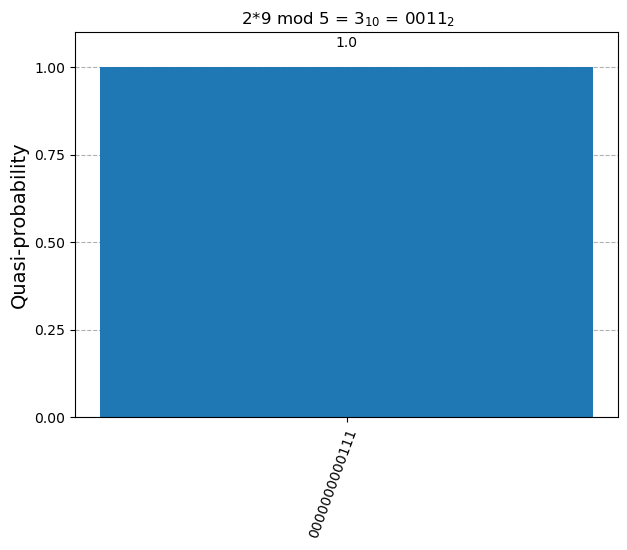

In [69]:
simMul(circ1,AerSimulator(),1000,x_val,y_val,N_val,n_qubits)

## Controlled Exponantiation mod N
just for testing purposes.

In [70]:
def CexpModN(n_qubits,y,a1,N):
    qubits = list(range(n_qubits))
    n = (n_qubits-5)//2 
    control = qubits[0:1]      # length 1
    x1 = qubits[1:n+1]   # length n
    x2 = qubits[(n+1):2*n+1] # length n  
    a = qubits[(2*n+1):]
    qc = QuantumCircuit(n_qubits,name=rf"C ${y}^{a1}$ Mod${N}$")
    gate = CmultModN(1+n+n+4,y,N)
    for _ in range(a1):
        qc.append(gate,control+x1+x2+a)
    return qc.to_instruction()

In [71]:
x_val =2
y_val = 3
N_val=7
# ensures that x register is large enough to fit arbitrary mod N operation
n_qubits = max(int(np.ceil(np.log2(x_val)+1)),int(np.ceil(np.log2(N_val)+1)) ) 
n_qubits

4

In [72]:
qr = QuantumRegister(n_qubits,'x')
qr1 = QuantumRegister(n_qubits,'z')
a = QuantumRegister(4,'a')
# c = QuantumRegister(2,'c')
control = QuantumRegister(1,'control')
circ2 = QuantumCircuit(control,qr,qr1,a)
for i in range(n_qubits):
        if (x_val & (1 << i)):
            circ2.x(qr[i])
circ2.x(control[0])
circ2.barrier()
circ2.append(CexpModN(circ2.num_qubits,y_val,2**3,N_val),circ2.qubits)
circ2.measure_all()

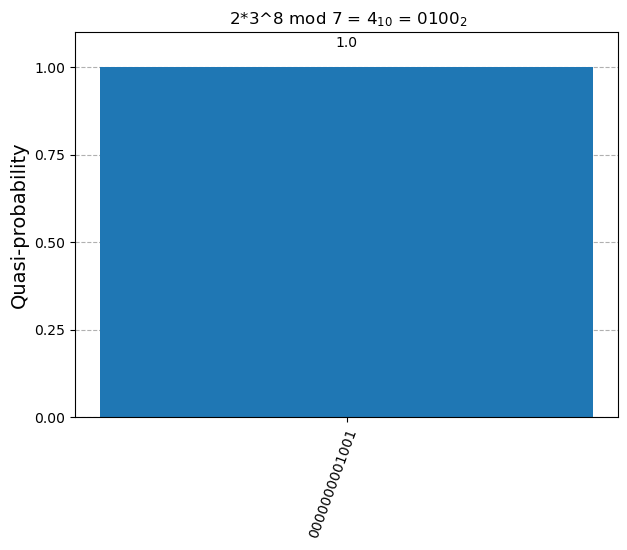

In [73]:
simMulExp(circ2, AerSimulator(), 1024,x_val,y_val,2**3,N_val,n_qubits)

## Phase estimation

In [74]:
def phase_estimation(n_qubits,t,n,m,N):
    """
    expectsd a circuit of t+n+n+4 qubits

    with registers qr, qrL,qrL2,a

    qr is the uper part of the phase estimation
    qrL is the lower part, here is the result of the multimlication saved
    qrL2 are the helper qubits of qrL
    a are the anchillas
    
    """
    qubits = list(range(n_qubits))
    qr = qubits[:t]
    qrL = qubits[t:t+n]
    qrL2 = qubits[t+n: t+2*n]
    a = qubits[t+2*n:]
    qc = QuantumCircuit(n_qubits,t,name="Phase Estimation")
    qc.h(qr)
    qc.x(qrL[0]) #hier muss eigenlich 0 hin
    gate = CmultModN(1+n+n+4,m,N)
    for i in range(t):
        for _ in range(2**i):
            qc.append(gate,[qr[i]]+qrL+qrL2+a)
    qc.append(QFT(t, inverse=True),qr)
    qc.measure(qr,qc.clbits)
    return qc.to_instruction()

In [75]:
n = 3
t = 2*n +3
# t=2

In [76]:
qr = QuantumRegister(t,'t') 
qrL = QuantumRegister(n,'L') 
qrL2 = QuantumRegister(n,'L2')
a = QuantumRegister(4,'a') 
cl = ClassicalRegister(t)
# cl1 = ClassicalRegister(n)
qc = QuantumCircuit(qr,qrL,qrL2,a,cl)
qc.append(phase_estimation(t+n+n+4,t,n,3,7),qc.qubits,cl)
# qc.measure_all()

In [77]:
result = simGetCounts(qc,AerSimulator(),10000)

In [78]:
result

{'110001100': 1,
 '101101101': 1,
 '111100101': 1,
 '001000111': 1,
 '110111110': 1,
 '000100010': 1,
 '011001100': 1,
 '001101100': 1,
 '010010001': 1,
 '001101011': 1,
 '110100001': 1,
 '110100011': 2,
 '001100011': 3,
 '110101010': 297,
 '001100000': 1,
 '101010010': 16,
 '010110000': 4,
 '010110011': 2,
 '001000100': 1,
 '110111001': 2,
 '010001010': 1,
 '010101110': 19,
 '001100010': 1,
 '011000001': 2,
 '101110110': 1,
 '010100011': 3,
 '001011001': 14,
 '010000010': 1,
 '101000111': 3,
 '101010000': 3,
 '101011010': 4,
 '010101111': 6,
 '010101100': 60,
 '001010001': 11,
 '101001100': 2,
 '110101011': 1136,
 '101011001': 10,
 '001010011': 18,
 '010100110': 7,
 '001010100': 72,
 '010100111': 4,
 '110101100': 71,
 '010101011': 1118,
 '010010110': 1,
 '101010100': 75,
 '110101101': 22,
 '010101101': 25,
 '110100110': 3,
 '001100001': 3,
 '010100100': 1,
 '101011000': 19,
 '010101000': 18,
 '001010101': 1176,
 '001010110': 269,
 '101100101': 1,
 '101010011': 32,
 '001101000': 1,
 '1

In [79]:
def continued_fraction_iterative1(x, iter=5000):
    if iter == 0 or isinstance(x, int):
        return int(np.floor(x))
    
    # Store the terms in reverse order
    terms = []
    current_x = x
    
    # Calculate all floor values first
    for _ in range(iter):
        floor_val = int(np.floor(current_x))
        terms.append(floor_val)
        
        # Break if we have a whole number
        if np.isclose(np.mod(current_x, 1), 0):
            break
            
        current_x = 1/np.mod(current_x, 1)
    
    # Build the fraction from bottom up
    result = terms[-1]  # Start with the last term
    
    # Work backwards through the terms
    for term in reversed(terms[:-1]):
        result = term + Fraction(1, result)
    
    return result

In [80]:
def continued_fraction_iterative(x, iter):
    # Store the terms in reverse order
    terms = []
    
    # Calculate all floor values first
    for _ in range(iter):
        a = int(x)
        terms.append(a)
        x -=a
        if np.isclose(x,0):
            break
        

            
        x = 1/x
    
    
    return terms

def get_den(cont_frac):
    q = [1,0]
    for i in range(len(cont_frac)):
        q.append(cont_frac[i]*q[-1]+q[-2])
    return q

Returns the highest r, which is smaller than N, if all satisfiy this return the last element (which should be the best approximation to phi)

In [81]:
def get_order(phi,N):
    estimated_r = get_den(continued_fraction_iterative(phi,5000))
    for i in range(len(estimated_r)):
        if estimated_r[i] < N:
            continue
        if i==0:
            return estimated_r[i]
        return estimated_r[i-1]
    return estimated_r[-1]
    

In [82]:
orders = []
for i in result:
    order = get_order(int(i,2)/2**t,7)
    orders.append(order)
    # brea
orders = np.array(orders)

In [83]:
orders

array([4, 3, 1, 1, 1, 1, 5, 5, 4, 5, 5, 6, 5, 6, 5, 3, 3, 3, 1, 1, 4, 3,
       5, 5, 4, 3, 6, 4, 3, 3, 3, 3, 3, 6, 3, 6, 3, 6, 3, 6, 3, 6, 3, 3,
       3, 6, 3, 6, 5, 3, 3, 3, 6, 6, 3, 3, 5, 3, 2, 6, 3, 6, 4, 3, 1, 5,
       3, 6, 6, 1, 1, 1, 1, 6, 3, 3, 3, 3, 6, 3, 6, 3, 3, 6, 3, 3, 5, 6,
       3, 6, 6, 5, 5, 5, 3, 5, 3, 5, 4, 5, 6, 3, 1, 6, 6, 6, 3, 5, 4, 2,
       6, 6, 6, 3, 4, 3, 3, 1, 3, 6, 1, 3, 1, 3, 5, 3, 6, 5, 6, 4, 5, 6,
       3, 6, 5, 4, 6, 5, 6, 3, 1, 5, 3, 5, 3, 3, 1, 3, 3, 1, 3, 5, 5, 5])

We can find the most likly by binning the result of the PE.

In [84]:
hits = np.zeros(7)
for key,value in zip(orders,result.values()):
    hits[key] += value

<BarContainer object of 7 artists>

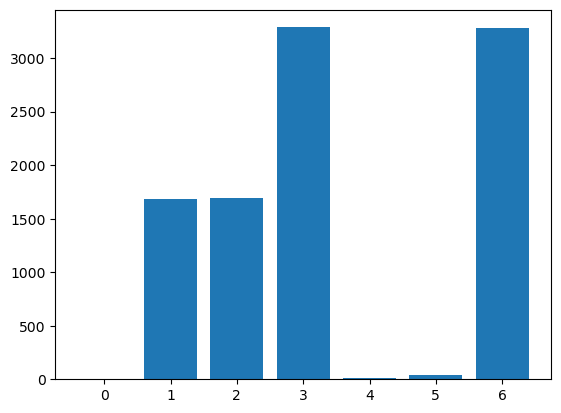

In [85]:
plt.bar(range(0,7),hits)

The most likly results are 3 & 6. One can check that 6 is the right answer.

In [86]:
3**6 %7

1

The succsess rate reads

In [87]:
hits[-1]/(sum(hits))*100

np.float64(32.85)

On avreage a acceptence rate of about 32% was achived.